# Conspiracy Analysis

## Data Exploration

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import spacy
import re
from collections import Counter
from typing import List, Dict, Tuple
from wordcloud import WordCloud

In [ ]:

loco = pd.read_json('./data/LOCO.json')
loco = loco[loco['subcorpus'] == 'conspiracy']
loco = loco[['website', 'seeds', 'title', 'txt', 'FB_shares', 'FB_comments', 'FB_reactions']]
loco

In [ ]:
loco.to_csv('./data/conspiracy.csv')

### Keyword Analysis

In [ ]:
websites = loco['website'].value_counts()
websites

In [ ]:
keywords = loco['seeds'].value_counts()
keywords

In [ ]:
compound_keywords = [el for el in keywords.index if (';' in el)]
compound_keywords

In [ ]:
multiple_compounds = loco[loco['seeds'].isin(compound_keywords)]['seeds'].value_counts()
multiple_compounds = multiple_compounds[multiple_compounds > 1]
multiple_compounds[0:20].plot(kind='bar', title="Top 20 Keyword Combinations")

In [ ]:
for key in compound_keywords:
    count = keywords[key]
    independent_keywords = [s.strip() for s in key.split(';')]
    keywords[independent_keywords] += count
    keywords.drop(key, inplace=True)

In [ ]:
keywords.sort_values(inplace=True, ascending=False)
keywords[0:20].plot(kind='bar', title="Top 20 Conspiracy Keywords")

In [ ]:
seeds = [el.replace('.', ' ') for el in loco['seeds'].value_counts().index if ';' not in el]
seeds.sort()
seeds

### Title Analysis

In [ ]:
def vectorized_clean(text_series: pd.Series) -> List[str]:
    non_letter_to_space = re.compile(r'[\-–—]')
    non_letter_to_empty = re.compile(r'([^a-z ])')
    multi_space = re.compile(r'[ ]{2,}')
    return text_series.str.lower().str.replace(non_letter_to_space, ' ').str.replace(non_letter_to_empty, '').str.replace(multi_space, ' ').to_list()

def spacy_clean(text_list: List[str], nlp: spacy.lang) -> List[str]:
    return [[token.lemma_ for token in title if ((not token.is_stop) and (len(token.text) > 1))] for title in nlp.pipe(titles)]

def count_words(text_list: List[str]) -> Dict[str, int]:
    counts = Counter()
    for el in text_list:
        counts += Counter(el)
    return counts

def give_sorted_counts(counter: Dict[str, int], reverse: bool =True) -> List[Tuple[str, int]]:
    return sorted(counter.items(), key=lambda x: x[1], reverse=reverse)

def make_word_cloud(counter: Dict[str, int]) -> None:
    wc = WordCloud(width=1280, height=720, scale=1.25)
    wc.generate_from_frequencies(counter)

    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [ ]:
nlp = spacy.load("en_core_web_md")

titles = vectorized_clean(loco['title'])
clean_titles = spacy_clean(titles, nlp)
title_counts = count_words(clean_titles)
give_sorted_counts(title_counts)

In [ ]:
make_word_cloud(title_counts)

### Body Analysis

In [ ]:
bodies = vectorized_clean(loco['txt'])
clean_bodies = spacy_clean(bodies, nlp)
body_counts = count_words(clean_bodies)
give_sorted_counts(body_counts)

In [ ]:
make_word_cloud(body_counts)

## Modelling

In [ ]:
texts = (loco['title'] + ': ' + loco['txt']).tolist()

### NER 

We tried using NER as a form of ersatz keyword extraction, but it ended up producing too many keywords, and thus wasn't very much use. This part of the notebook is here mostly for reference.

In [ ]:
from itertools import combinations

apostrophe_re = re.compile(r"[’']s")

def should_include_ne(name: str, ne_type: str) -> bool:
    irrelevant_nes = {'TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL', 'DATE', 'GPE', 'NORP'}
    is_911 = (name == '9/11') and ne_type in irrelevant_nes
    return is_911 or (ne_type not in irrelevant_nes)

def clean_entity_name(ne: str) -> str:
    return re.sub(apostrophe_re, '', ne)

def filter_entities(ne_list: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    return list(set([(clean_entity_name(name), ent_type) for name, ent_type in ne_list if should_include_ne(name, ent_type)]))

def create_pairings(texts: List[str]) -> Dict[Tuple[Tuple[str]], int]:
    title_named_entities = [[(token.text, token.label_) for token in title.ents] for title in nlp.pipe(texts)]
    title_named_entities = [filter_entities(el) for el in title_named_entities if len(el) > 0]
    ne_pairs = Counter()

    for article in title_named_entities:
        ne_pairs += Counter(combinations(article, 2))

    return ne_pairs

spacy.prefer_gpu()
nlp = spacy.load("en_core_web_trf")


In [ ]:
ne_pairs = create_pairings(texts[:200])
ne_pairs

In [ ]:
ne_df = []

for nes, count in ne_pairs.items():
    ne1, ne2 = nes
    # ne_df.append({'ne1': ne1[0], 'ne1_type': ne1[1], 'ne2': ne2[0], 'ne2_type': ne2[1], 'count': count})
    ne_df.append({'ne1': ne1[0], 'ne2': ne2[0], 'weight': count})

ne_df = pd.DataFrame(ne_df)
ne_df = ne_df[ne_df['weight'] > 1]

In [ ]:
ne_df.sort_values('weight', ascending=False)

In [ ]:
import networkx as nx
from pyvis.network import Network

G = nx.from_pandas_edgelist(ne_df, 'ne1', 'ne2', edge_attr='weight')
nt = Network('500px', '500px', notebook=True)
# populates the nodes and edges data structures
nt.from_nx(G)
nt.show('nx.html')

### KeyBERT

In [18]:
from keybert import KeyBERT
import spacy
import json
from itertools import combinations
from collections import Counter
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from random import randint
from typing import List
import re

#### Word Pair Generation

In [ ]:
CHUNK = 5000
conspiracies = pd.read_csv('./data/conspiracy.csv', iterator=True, chunksize=CHUNK, index_col=0)

In [ ]:
with open('./conspiracies.json', 'r') as f:
    seeds = json.load(f)

spacy.prefer_gpu()
keybert_model = spacy.load("en_core_web_trf", exclude=['tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer'])
kw_model = KeyBERT(model=keybert_model)

mentions = Counter()
pairs = []
words = []

In [ ]:
validation_set = []

def generate_sample_inds(n: int, size: int = CHUNK) -> List[int]:  
    samples = [randint(0, size) for _ in range(n)]
    while len(samples) != len(set(samples)):
        samples = [randint(0, size) for _ in range(n)]
    return samples

In [ ]:
newline_re = re.compile(r'(\r\n|\n)+')

for chunk in tqdm(conspiracies):
    texts = (chunk['txt'].str.replace(newline_re, ' ')).tolist()

    keywords = kw_model.extract_keywords(texts, candidates=seeds, keyphrase_ngram_range=(1,3), top_n=10, use_mmr=True)
    words += keywords
    # empty_indices = set([i for i, k in enumerate(keywords) if len(k) == 0])
    validation_set += [(texts[i], keywords[i]) for i in generate_sample_inds(len(chunk) // 1000, len(chunk))]
    keywords = [[name for name, _ in article] for article in keywords if len(article) > 0]

In [ ]:
key_counts = mentions.most_common()
# pair_counts = pair_count_dict.most_common()

In [ ]:
validation_set

In [ ]:
with open('./data/keyword_instances.json', 'w') as f:
    json.dump([[w[0] for w in article] for article in words], f)

with open('./data/validation.json', 'w') as f:
    json.dump(validation_set, f)

#### Rule Mining

In [19]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

with open('./data/keyword_instances.json', 'r') as f:
    words = json.load(f)


In [20]:
# some keywords are near-duplicates of each other to ensure that variants are picked up.
# this needs to be corrected before the next steps to get accurate counts
duplicates = {
    'obama': 'barack obama',
    'coronavirus': 'covid',
    'trump': 'donald trump',
    'eu': 'european union',
    'biden': 'joe biden',
    'epstein': 'jeffrey epstein',
    'john f kennedy': 'jfk',
    'nwo': 'new world order',
    'pedophiles': 'pedophilia',
    'Q': 'qanon',
    'unidentified flying object': 'ufo'
}

words = [list(set([duplicates[el] if el in duplicates else el for el in article])) for article in words if len(article) > 0]
words


[['satanism', 'mind control', 'pedophilia', 'george bush', 'aids'],
 ['clinton',
  'barack obama',
  'donald trump',
  'robert mueller',
  'george bush',
  'james comey'],
 ['osama bin laden', 'saddam hussein'],
 ['holocaust', 'cancer', 'aids', 'vaccine'],
 ['climate change'],
 ['donald trump', 'big pharma', 'deep state'],
 ['osama bin laden',
  'muslims',
  'communism',
  'jews',
  'saudi',
  'new world order',
  'rothschild',
  'george bush'],
 ['clinton', 'extraterrestrial'],
 ['clinton', 'donald trump', '2016 election'],
 ['cancer'],
 ['vaccine', 'vaccine covid', 'covid'],
 ['fluoride'],
 ['donald trump', 'covid', 'bible'],
 ['hillary clinton',
  'clinton',
  'joe biden',
  'deep state',
  'jeffrey epstein',
  'donald trump',
  'james comey'],
 ['barack obama',
  'fluoride',
  'cancer',
  'population control',
  'new world order'],
 ['zika'],
 ['cancer'],
 ['barack obama', 'aids'],
 ['covid'],
 ['illuminati',
  'federal reserve',
  'antichrist',
  'satanism',
  'bible',
  'new worl

In [21]:
counts = [Counter(w) for w in words if len(w) > 0]
key_df = pd.DataFrame(counts).fillna(0).astype(bool)
key_df.head()

,satanism,mind control,pedophilia,george bush,aids,clinton,barack obama,donald trump,robert mueller,james comey,...,elvis presley,cia cocaine,nibiru,2000 election,michael jackson death,mayan calendar,big foot,elvis death,crisis actor,paul mccartney death
0,True,True,True,True,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,True,False,True,True,True,True,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [22]:
key_counts = Counter()
for el in counts:
    key_counts += el

key_counts

Counter({'satanism': 372,
         'mind control': 1306,
         'pedophilia': 486,
         'george bush': 1901,
         'aids': 997,
         'clinton': 2394,
         'barack obama': 3419,
         'donald trump': 4473,
         'robert mueller': 217,
         'james comey': 181,
         'osama bin laden': 865,
         'saddam hussein': 861,
         'holocaust': 527,
         'cancer': 2877,
         'vaccine': 3023,
         'climate change': 1585,
         'big pharma': 1777,
         'deep state': 1438,
         'muslims': 695,
         'communism': 679,
         'jews': 989,
         'saudi': 1140,
         'new world order': 2689,
         'rothschild': 766,
         'extraterrestrial': 353,
         '2016 election': 226,
         'vaccine covid': 50,
         'covid': 2957,
         'fluoride': 551,
         'bible': 1367,
         'hillary clinton': 1262,
         'joe biden': 474,
         'jeffrey epstein': 333,
         'population control': 668,
         'zika': 313,

##### All Sets

In [6]:
frequent_itemsets = apriori(key_df, use_colnames=True, min_support=0.01)
frequent_itemsets

,support,itemsets
0,0.017480,(satanism)
1,0.061366,(mind control)
2,0.022836,(pedophilia)
3,0.089324,(george bush)
4,0.046847,(aids)
...,...,...
181,0.011136,"(european union, donald trump, barack obama)"
182,0.015882,"(vaccine, donald trump, covid)"
183,0.011230,"(donald trump, big pharma, deep state)"
184,0.010290,"(global warming, climate change, united nations)"


In [7]:
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(new world order),(mind control),0.126351,0.061366,0.018513,0.146523,2.387672,0.010760,1.099776
1,(mind control),(new world order),0.061366,0.126351,0.018513,0.301685,2.387672,0.010760,1.251081
2,(illuminati),(mind control),0.077906,0.061366,0.021568,0.276840,4.511255,0.016787,1.297960
3,(mind control),(illuminati),0.061366,0.077906,0.021568,0.351455,4.511255,0.016787,1.421788
4,(mind control),(mk ultra),0.061366,0.013861,0.010807,0.176110,12.705012,0.009957,1.196930
...,...,...,...,...,...,...,...,...,...
271,"(donald trump, barack obama)","(hillary clinton, clinton)",0.063199,0.055775,0.018184,0.287732,5.158820,0.014659,1.325661
272,(hillary clinton),"(clinton, barack obama, donald trump)",0.059299,0.027817,0.018184,0.306656,11.024080,0.016535,1.402166
273,(clinton),"(hillary clinton, donald trump, barack obama)",0.112489,0.019265,0.018184,0.161654,8.391032,0.016017,1.169845
274,(barack obama),"(hillary clinton, clinton, donald trump)",0.160652,0.034254,0.018184,0.113191,3.304432,0.012681,1.089012


In [8]:
rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
176,(jfk),(jfk assassination),0.034066,0.012875,0.012640,0.371034,28.818817,0.012201,1.569443
177,(jfk assassination),(jfk),0.012875,0.034066,0.012640,0.981752,28.818817,0.012201,52.933164
4,(mind control),(mk ultra),0.061366,0.013861,0.010807,0.176110,12.705012,0.009957,1.196930
5,(mk ultra),(mind control),0.013861,0.061366,0.010807,0.779661,12.705012,0.009957,4.259952
270,"(barack obama, hillary clinton)","(clinton, donald trump)",0.028146,0.051922,0.018184,0.646077,12.443264,0.016723,2.678768
...,...,...,...,...,...,...,...,...,...
46,(federal reserve),(donald trump),0.049009,0.210178,0.011559,0.235858,1.122185,0.001259,1.033607
64,(new world order),(barack obama),0.126351,0.160652,0.022507,0.178133,1.108812,0.002209,1.021270
65,(barack obama),(new world order),0.160652,0.126351,0.022507,0.140099,1.108812,0.002209,1.015989
130,(big pharma),(covid),0.083498,0.138944,0.011982,0.143500,1.032794,0.000380,1.005320


In [9]:
rules.sort_values('lift', ascending=False).iloc[:10]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
176,(jfk),(jfk assassination),0.034066,0.012875,0.012640,0.371034,28.818817,0.012201,1.569443
177,(jfk assassination),(jfk),0.012875,0.034066,0.012640,0.981752,28.818817,0.012201,52.933164
4,(mind control),(mk ultra),0.061366,0.013861,0.010807,0.176110,12.705012,0.009957,1.196930
5,(mk ultra),(mind control),0.013861,0.061366,0.010807,0.779661,12.705012,0.009957,4.259952
270,"(barack obama, hillary clinton)","(clinton, donald trump)",0.028146,0.051922,0.018184,0.646077,12.443264,0.016723,2.678768
267,"(clinton, donald trump)","(barack obama, hillary clinton)",0.051922,0.028146,0.018184,0.350226,12.443264,0.016723,1.495681
164,(bible),(antichrist),0.064233,0.015036,0.011089,0.172641,11.481693,0.010123,1.190491
165,(antichrist),(bible),0.015036,0.064233,0.011089,0.737500,11.481693,0.010123,3.564828
231,(hillary clinton),"(clinton, donald trump)",0.059299,0.051922,0.034254,0.577655,11.125469,0.031175,2.244793
226,"(clinton, donald trump)",(hillary clinton),0.051922,0.059299,0.034254,0.659729,11.125469,0.031175,2.764560


In [10]:
rules.sort_values('lift', ascending=False).iloc[50:60]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
169,(chemtrails),(global warming),0.036275,0.066065,0.012217,0.336788,5.097804,0.009820,1.408199
168,(global warming),(chemtrails),0.066065,0.036275,0.012217,0.184922,5.097804,0.009820,1.182371
134,(big pharma),(pharmaceutical industry),0.083498,0.038342,0.016305,0.195273,5.092890,0.013103,1.195011
135,(pharmaceutical industry),(big pharma),0.038342,0.083498,0.016305,0.425245,5.092890,0.013103,1.594597
180,"(new world order, illuminati)",(mind control),0.037731,0.061366,0.010854,0.287671,4.687764,0.008539,1.317697
181,(mind control),"(new world order, illuminati)",0.061366,0.037731,0.010854,0.176876,4.687764,0.008539,1.169044
124,(deep state),(big pharma),0.067569,0.083498,0.025984,0.384562,4.605653,0.020343,1.489187
125,(big pharma),(deep state),0.083498,0.067569,0.025984,0.311199,4.605653,0.020343,1.353701
3,(illuminati),(mind control),0.077906,0.061366,0.021568,0.276840,4.511255,0.016787,1.297960
2,(mind control),(illuminati),0.061366,0.077906,0.021568,0.351455,4.511255,0.016787,1.421788


In [11]:
rules_to_save = rules.sort_values('lift', ascending=False)
rules_to_save['antecedents'] = rules_to_save['antecedents'].apply(lambda x: ', '.join(x)).astype(str)
rules_to_save['consequents'] = rules_to_save['consequents'].apply(lambda x: ', '.join(x)).astype(str)

rules_to_save.to_csv('./data/assoc_rules.csv', index=False)

##### Only Pairs

In [23]:
frequent_pairs = apriori(key_df, use_colnames=True, min_support=0.001, max_len=2)
frequent_pairs

,support,itemsets
0,0.017480,(satanism)
1,0.061366,(mind control)
2,0.022836,(pedophilia)
3,0.089324,(george bush)
4,0.046847,(aids)
...,...,...
1406,0.001457,"(reptilian, atlantis)"
1407,0.001081,"(reptilian, freemasons)"
1408,0.001927,"(mass shooting, sandy hook)"
1409,0.001410,"(freemasons, apocalypse)"


In [24]:
pair_rules = association_rules(frequent_pairs, metric='lift', min_threshold=1.1)
pair_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(satanism),(mind control),0.017480,0.061366,0.006061,0.346774,5.650879,0.004989,1.436921
1,(mind control),(satanism),0.061366,0.017480,0.006061,0.098775,5.650879,0.004989,1.090205
2,(pedophilia),(satanism),0.022836,0.017480,0.002913,0.127572,7.298354,0.002514,1.126191
3,(satanism),(pedophilia),0.017480,0.022836,0.002913,0.166667,7.298354,0.002514,1.172597
4,(satanism),(george bush),0.017480,0.089324,0.002960,0.169355,1.895955,0.001399,1.096347
...,...,...,...,...,...,...,...,...,...
1729,(sandy hook),(mass shooting),0.016728,0.006954,0.001927,0.115169,16.560925,0.001810,1.122299
1730,(freemasons),(apocalypse),0.020017,0.012546,0.001410,0.070423,5.613230,0.001159,1.062261
1731,(apocalypse),(freemasons),0.012546,0.020017,0.001410,0.112360,5.613230,0.001159,1.104032
1732,(antifa),(mark zuckerberg),0.007518,0.007377,0.001786,0.237500,32.194108,0.001730,1.301800


In [25]:
pair_rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1707,(antifa),(black lives matter),0.007518,0.006437,0.002443,0.325000,50.486496,0.002395,1.471945
1706,(black lives matter),(antifa),0.006437,0.007518,0.002443,0.379562,50.486496,0.002395,1.599647
1331,(joe biden),(hunter biden),0.022272,0.003101,0.003101,0.139241,44.898734,0.003032,1.158162
1330,(hunter biden),(joe biden),0.003101,0.022272,0.003101,1.000000,44.898734,0.003032,inf
1709,(mark zuckerberg),(black lives matter),0.007377,0.006437,0.001880,0.254777,39.577851,0.001832,1.333242
...,...,...,...,...,...,...,...,...,...
990,(ufo),(jews),0.023823,0.046471,0.001222,0.051282,1.103523,0.000115,1.005071
1616,(george soros),(jfk),0.041303,0.034066,0.001551,0.037543,1.102045,0.000144,1.003612
1617,(jfk),(george soros),0.034066,0.041303,0.001551,0.045517,1.102045,0.000144,1.004416
394,(barack obama),(alex jones),0.160652,0.026031,0.004605,0.028663,1.101107,0.000423,1.002710


In [26]:
pair_rules['antecedents'] = pair_rules['antecedents'].apply(lambda x: list(x)[0]).astype(str)
pair_rules['consequents'] = pair_rules['consequents'].apply(lambda x: list(x)[0]).astype(str)
pair_rules.sort_values('lift', ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1707,antifa,black lives matter,0.007518,0.006437,0.002443,0.325000,50.486496,0.002395,1.471945
1706,black lives matter,antifa,0.006437,0.007518,0.002443,0.379562,50.486496,0.002395,1.599647
1331,joe biden,hunter biden,0.022272,0.003101,0.003101,0.139241,44.898734,0.003032,1.158162
1330,hunter biden,joe biden,0.003101,0.022272,0.003101,1.000000,44.898734,0.003032,inf
1709,mark zuckerberg,black lives matter,0.007377,0.006437,0.001880,0.254777,39.577851,0.001832,1.333242
...,...,...,...,...,...,...,...,...,...
990,ufo,jews,0.023823,0.046471,0.001222,0.051282,1.103523,0.000115,1.005071
1616,george soros,jfk,0.041303,0.034066,0.001551,0.037543,1.102045,0.000144,1.003612
1617,jfk,george soros,0.034066,0.041303,0.001551,0.045517,1.102045,0.000144,1.004416
394,barack obama,alex jones,0.160652,0.026031,0.004605,0.028663,1.101107,0.000423,1.002710


#### Visualization

In [27]:
rule_list = pair_rules[['antecedents', 'consequents', 'lift']]
rule_list['lift'] = (rule_list['lift'] / rule_list['lift'].max()) * 10
rule_list

/tmp/ipykernel_1470/1216303490.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rule_list['lift'] = (rule_list['lift'] / rule_list['lift'].max()) * 10


,antecedents,consequents,lift
0,satanism,mind control,1.119285
1,mind control,satanism,1.119285
2,pedophilia,satanism,1.445605
3,satanism,pedophilia,1.445605
4,satanism,george bush,0.375537
...,...,...,...
1729,sandy hook,mass shooting,3.280268
1730,freemasons,apocalypse,1.111828
1731,apocalypse,freemasons,1.111828
1732,antifa,mark zuckerberg,6.376776


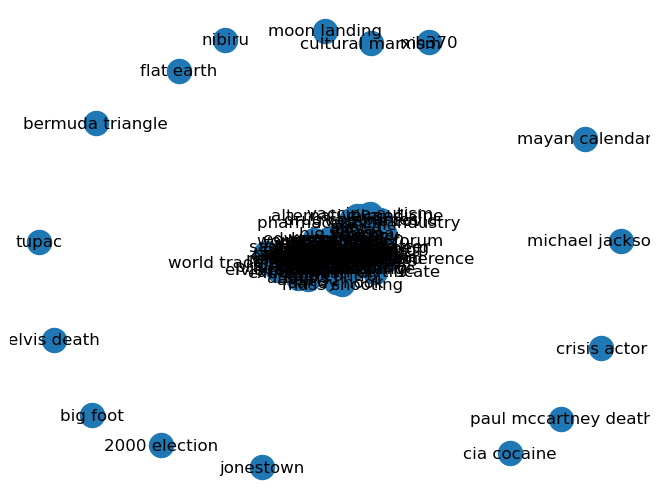

In [28]:
G = nx.DiGraph()
key_counts = dict(key_counts)

for k in key_counts.keys():
    G.add_node(k, label=k, size=key_counts[k])

for row in rule_list.values.tolist():
    G.add_edge(row[0], row[1], weight=row[2])


# pos = nx.spring_layout(G, seed=7)

# nx.draw_networkx_edges(G, pos, width=list(nx.get_edge_attributes(G, "weight").values()))

# # node labels
# nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# nx.draw_networkx_nodes(G,pos,node_size=[key_counts[n] for n in G.nodes])
nx.draw(G, with_labels=True)

In [29]:
key_counts = dict(key_counts)
max_count = key_counts[max(key_counts, key= lambda x: key_counts[x])]

In [37]:
from d3graph import d3graph, vec2adjmat


source = rule_list['antecedents'].to_list()
target = rule_list['consequents'].to_list()
weights = rule_list['lift'].to_list()

adjmat = vec2adjmat(source, target, weight=weights)

# Initialize
d3 = d3graph(collision=3, charge=25000)
# Proces adjmat
d3.graph(adjmat)

# d3.set_node_properties(size=[key_counts[n] for n in adjmat.columns])
d3.set_node_properties(fontcolor='midnightblue', fontsize=16, edge_size=1)
for node in d3.node_properties.keys():
    d3.node_properties[node]['size'] = (key_counts[node.replace('_', ' ')] / max_count) * 50
    d3.node_properties[node]['label'] = node.replace('_', ' ')
    d3.node_properties[node]['color'] = 'green'

d3.set_edge_properties(edge_distance=100, directed=True)

[d3graph] INFO> Set directed=True to see the markers!
[d3graph] INFO> Keep only edges with weight>0
[d3graph] INFO> Number of unique nodes: 95
[d3graph] INFO> Number of unique nodes: 95
[d3graph] INFO> Keep only edges with weight>0


[colourmap]> Warning: Colormap [Set1] can not create [15] unique colors! Available unique colors: [9].


In [38]:
d3.show(filepath='./web/conspiracy_map.html')

[d3graph] INFO> Slider range is set to [0, 10]
[d3graph] INFO> Write to path: [/home/ldtcoop/projects/conspiracy-network/index.html]
[d3graph] INFO> File already exists and will be overwritten: [/home/ldtcoop/projects/conspiracy-network/index.html]
